# Visualization and metrics modules

In this tutorial notebook, we provide examples on how to use MultiVae's `Evaluators` modules to compute metrics, and visualizations for a trained model. 

The following modules are available, that inherits from the `multivae.metrics.base.BaseEvaluator` class. 

- Likelihoods: to compute the joint likelihood of models
- Coherences: to compute cross-modal and joint coherence. For those, pretrained classifiers are necessary. 
- FIDs: To compute Fréchet Inception distance for generated images. 
- Visualization: to generate and save samples of cross-modal generation, or joint generation.
- Clustering : to perform clustering in the latent space and compute clustering accuracy. 


To demonstrate the use of this models, we load a pretrained model from HuggingFace.
If you don't already have it installed, run:
```pip install huggingface_hub``` to install it. 


In [1]:
from multivae.models import AutoModel

# download the model in one line
model = AutoModel.load_from_hf_hub('asenella/reproducing_mvtcae_seed_0', allow_pickle=True)

/home/agathe/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Successfully downloaded encoders architecture.
Successfully downloaded decoders architecture.
Successfully downloaded MVTCAE model!


In [2]:
# load a test set
from multivae.data.datasets.mmnist import MMNISTDataset

test_set = MMNISTDataset(data_path='./data',
                         download=True, 
                         split='test', 
                         )

1120666624it [13:37, 1371625.37it/s]                                


Extracting /tmp/tmp6e8xkkxi/PolyMNIST.zip to ./data


## Likelihood

In [3]:
from multivae.metrics import LikelihoodsEvaluator, LikelihoodsEvaluatorConfig

ll_config = LikelihoodsEvaluatorConfig(
    batch_size=128,
    num_samples=3, # number of importance samples per datapoint
    # wandb_path= 'your_wandb_path' # optional: the user can provide a wandb_path to log metrics on wandb.
)

ll_module = LikelihoodsEvaluator(model=model,
                                 output='./metrics',# where to log the metrics
                                 test_dataset=test_set,
                                 eval_config=ll_config)


In the `LikelihoodsEvaluatorConfig` dataclass, a wandb path can be provided. If you want to use an existing path (for instance the one used during training), you can get the path from the web interface 'Run overview' page. Otherwise, you can create a new wandb run and input the path to the config module:
```python
import wandb
wandb_run = wandb.init(entity='your_entity', project='your_project')
wandb_path = wandb_run.path
```
Each `Evaluator` module has an `eval()` function that computes standard metrics, but also contains other functions, to compute custom metrics. Don't hesitate to look for available functions in the documentation.

In [4]:
ll_module.eval()

100%|██████████| 79/79 [00:24<00:00,  3.25it/s]
Joint likelihood : tensor(6046.8770)


ModelOutput([('joint_likelihood', tensor(6046.8770))])

In [5]:
ll_module.finish() # closes files handler and finish wandb run.

## Coherences

To compute coherences, you need to first download the PolyMNIST classifiers available at https://zenodo.org/record/4899160#.ZGeXzy0isf_
and place them in a `./data/clf/` folder at the same location of this notebook. 

Otherwise, untrained classifiers will be used. 

In [11]:
import torch
from torch import nn
import os

#### Define the classifiers architectures

class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)


class ClfImg(nn.Module):
    """
    MNIST image-to-digit classifier. Roughly based on the encoder from:
    https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb
    """

    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(  # input shape (3, 28, 28)
            nn.Conv2d(3, 10, kernel_size=4, stride=2, padding=1),  # -> (10, 14, 14)
            nn.Dropout2d(0.5),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=4, stride=2, padding=1),  # -> (20, 7, 7)
            nn.Dropout2d(0.5),
            nn.ReLU(),
            Flatten(),  # -> (980)
            nn.Linear(980, 128),  # -> (128)
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(128, 10),  # -> (10)
        )

    def forward(self, x):
        h = self.encoder(x)
        # return F.log_softmax(h, dim=-1)
        return h


def load_mmnist_classifiers(data_path="your_data_path", device="cuda"):
    '''
    Function to load the classifiers state_dict.
    '''
    clfs = {}
    for i in range(5):
        fp = os.path.join(data_path,"pretrained_img_to_digit_clf_m" + str(i))
        model_clf = ClfImg()
        
        if os.path.exists(fp):
            model_clf.load_state_dict(torch.load(fp, map_location=torch.device(device)))
        else :
            print('Careful, untrained classifiers are used!')
            
        model_clf = model_clf.to(device)
        clfs["m%d" % i] = model_clf
    for m, clf in clfs.items():
        if clf is None:
            raise ValueError("Classifier is 'None' for modality %s" % str(i))
    return clfs



In [12]:
clfs = load_mmnist_classifiers('./data/clf', device = 'cpu')
# is a dictionary with one network per modality

In [13]:
from multivae.metrics import CoherenceEvaluator, CoherenceEvaluatorConfig

coherences_config = CoherenceEvaluatorConfig(batch_size=128,
                                             nb_samples_for_joint=100,
                                            #  wandb_path='your_wand_path'
                                             )

coherences_module = CoherenceEvaluator(model=model, 
                                       classifiers=clfs,
                                       output='./metrics',
                                       test_dataset=test_set
                                       )



The `Coherences` module also has an extensive `eval()`function that computes all cross-modal coherences along with the joint coherence.
But if you can also use other functions adapted to your precise metric needs. For instance you can choose to only compute the joint coherence:

In [14]:


coherences_module.joint_coherence()
coherences_module.finish()


Joint coherence with sampler prior: 0.004600000102072954


## Visualization

Finally we demonstrate how to use the Visualization module.

In [15]:
from multivae.metrics.visualization import Visualization, VisualizationConfig


vis_config = VisualizationConfig(batch_size=128,
                                #  wandb_path='your_wandb_path', # optional, if you have initialized a wandb run
                                 n_samples=5, # number of generated samples
                                 n_data_cond=8, # For conditional generation, the number of datapoints to use.
                                 )

vis_module = Visualization(model, test_dataset=test_set,
                           output='./metrics',
                           eval_config=vis_config)

# Here the eval function produces samples generated from the prior.

output = vis_module.eval()

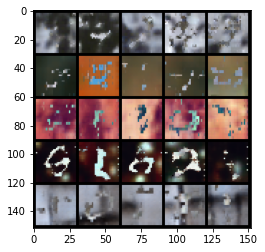

In [16]:
# The image is returned by the function and also saved in the output directory

from matplotlib import pyplot as plt 

plt.imshow(output.unconditional_generation)

The Visualization Module can also be used for conditional generation.

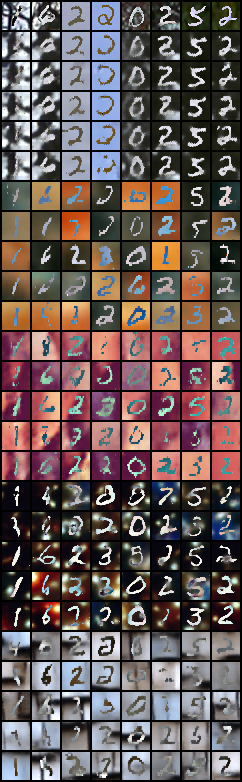

In [17]:
output = vis_module.conditional_samples_subset(['m0']) # Sample images conditioning one the first modality
output

## Other metrics

Other metrics modules have the same API has the ones presented here: a config dataclass and a evaluator class with an eval() function that computes the most standards metrics. 

You can also see more examples on https://github.com/AgatheSenellart/nips_experiments

Metrics modules such as Coherences, or Visualization can also be used with a dedicated sampler for joint generation. To know more about this, there is another tutorial.